In [1]:
# tool kit
import warnings
warnings.filterwarnings('ignore')

# algumas blibliotecas para manipulação de dados:
import math as m
import numpy as np
import pandas as pd
import quandl

# algumas bibliotecas para data-viz:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go

# algumas bibliotecas para processamento de dados ordenados - time series:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import pmdarima as pm
from pylab import rcParams

# algumas bibliotecas para avaliação dos nossos modelos:
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

Para a modelagem utilizaremos a variação percentual mensal do IPCA cheio, que é a série 433 do Banco Central, 
com início em janeiro de 1980 e término em fevereiro de 2022.

In [2]:
quandl.ApiConfig.api_key = 'shCQY59FKuyTRTcCyQp9' 

# Inflation
data = quandl.get('BCB/433')

In [3]:
data.rename(columns={'Value': 'ipca_mensal'}, inplace = True)

In [4]:
data.head()

ipca_mensal
Date                   
1980-01-31         6.62
1980-02-29         4.62
1980-03-31         6.04
1980-04-30         5.29
1980-05-31         5.70

In [5]:
data.tail()

ipca_mensal
Date                   
2021-10-31         1.25
2021-11-30         0.95
2021-12-31         0.73
2022-01-31         0.54
2022-02-28         1.01

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 506 entries, 1980-01-31 to 2022-02-28
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ipca_mensal  506 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB


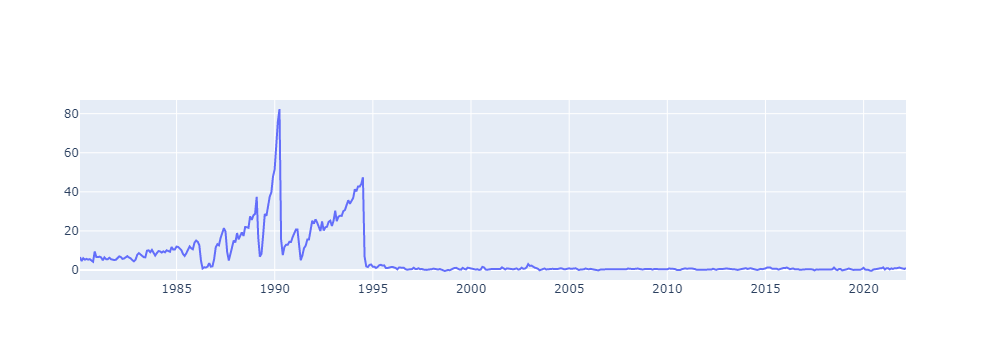

In [7]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(x=data.index, y=data['ipca_mensal'],
                    mode='lines',
                    name='Original'))


Observe a forte quebra da série em 1994, esse é o nosso sombrio histórico de inflação. Em 1994 o Plano Real consegue por um fim nesse processo inflacionário, depois temos um choque inflacionário em 2002/2003, decorrente da candidatura e vitória de Lula para a presidência e por final, temos uma tendência de queda da série em 2005/2006 e devido a isto vamos utilizar os dados a partir de Fevereiro de 2007.

In [8]:
data = data['2007-02-01':]
data.head()

ipca_mensal
Date                   
2007-02-28         0.44
2007-03-31         0.37
2007-04-30         0.25
2007-05-31         0.28
2007-06-30         0.28

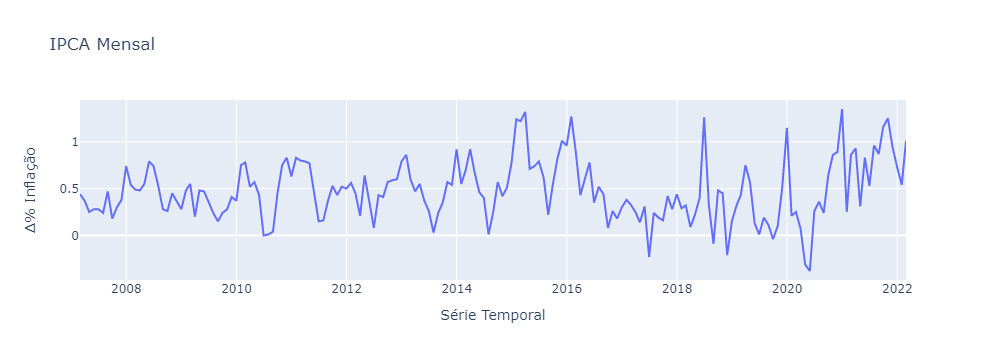

In [9]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(x=data.index, 
                          y=data['ipca_mensal'],
                          mode='lines',
                          name='Original')
              )
fig1.update_layout(title = 'IPCA Mensal')
fig1.update_xaxes(title = 'Série Temporal')
fig1.update_yaxes(title = 'Δ% Inflação')


# EDA

In [10]:
print(f'min: {data.index.min()} | max: {data.index.max()}')

min: 2007-02-28 00:00:00 | max: 2022-02-28 00:00:00


In [11]:
data.describe().T

count      mean       std   min   25%   50%   75%   max
ipca_mensal  181.0  0.477514  0.319817 -0.38  0.26  0.45  0.67  1.35

In [12]:
data.index.month.unique()

Int64Index([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1], dtype='int64', name='Date')

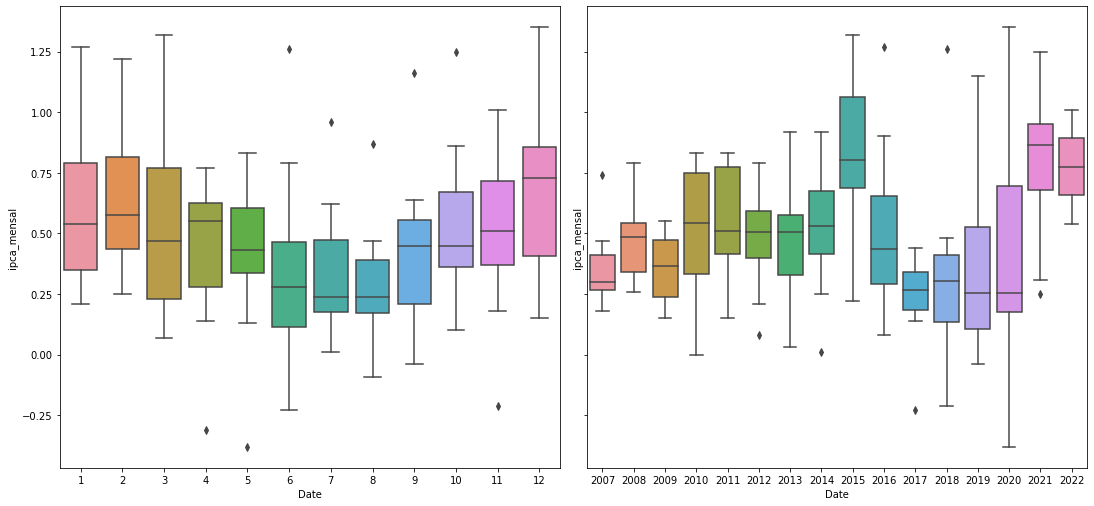

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15,7), sharey=True)
fig.tight_layout()
sns.boxplot(x=data.index.month, y=data.iloc[:, 0], orient='v', ax=ax[0])
sns.boxplot(x=data.index.year, y=data.iloc[:, 0], orient='v', ax=ax[1]);

### Vamos realizar uma decomposição aditiva da nossa série, e estudar sua tendência, sazonalidade e resíduo.

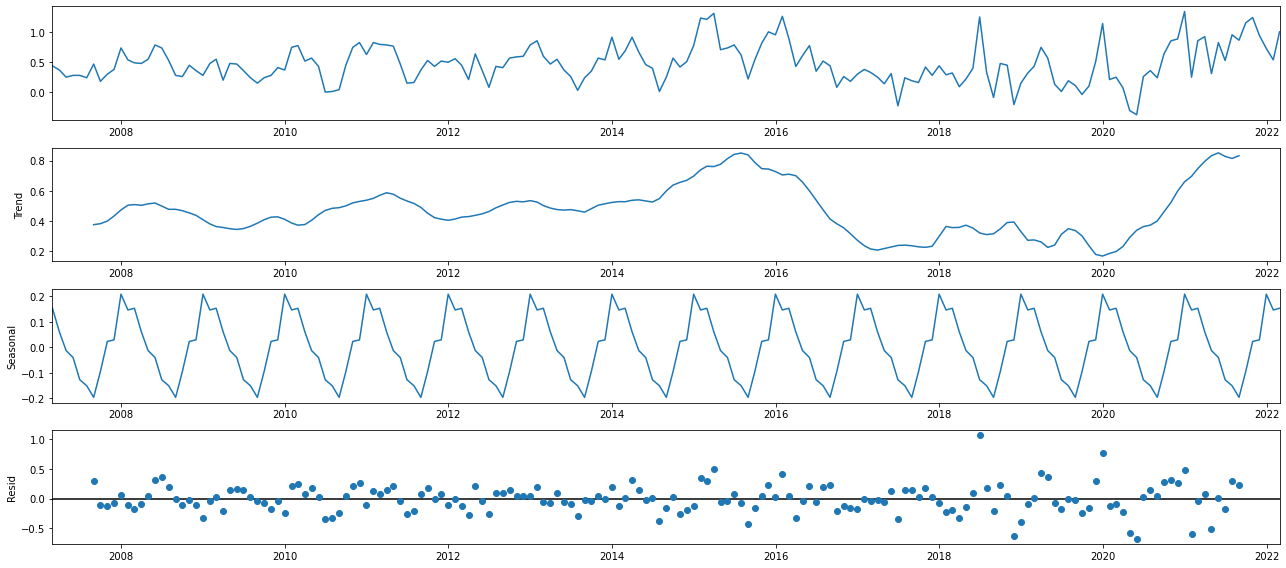

In [14]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive')
fig = decomposition.plot()
plt.show()

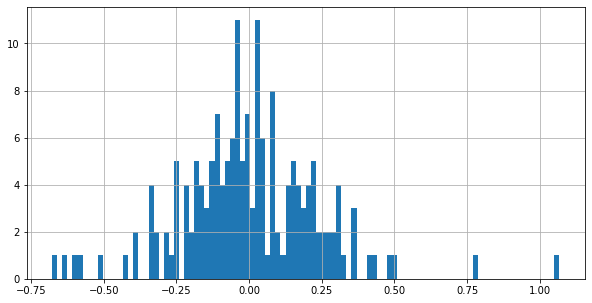

In [15]:
resid = decomposition.resid
plt.figure(figsize=(10, 5))
resid.hist(bins=100);

### Teste de estacionariedade da série

In [16]:
#Ho: Não é estacionário
#H1: É estacionário

def adfuller_test(timeseries, window= 12):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    result=adfuller(timeseries)
    
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
   
    # se a significância estiver abaixo de 0.05, significa que há pouca influência nos dados. 
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis, indicating it is non-stationary ")

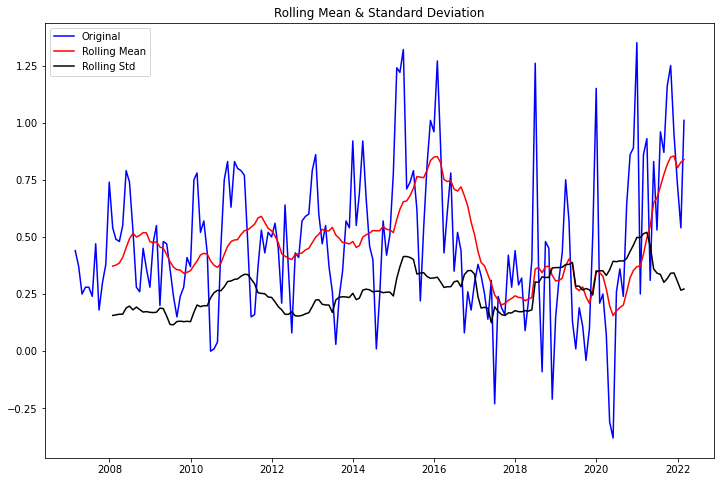

ADF Test Statistic : -2.20566868375425
p-value : 0.20419448870971751
#Lags Used : 8
Number of Observations Used : 172
weak evidence against null hypothesis, indicating it is non-stationary 


In [17]:
adfuller_test(data)

#### Diferenciação Sazonal

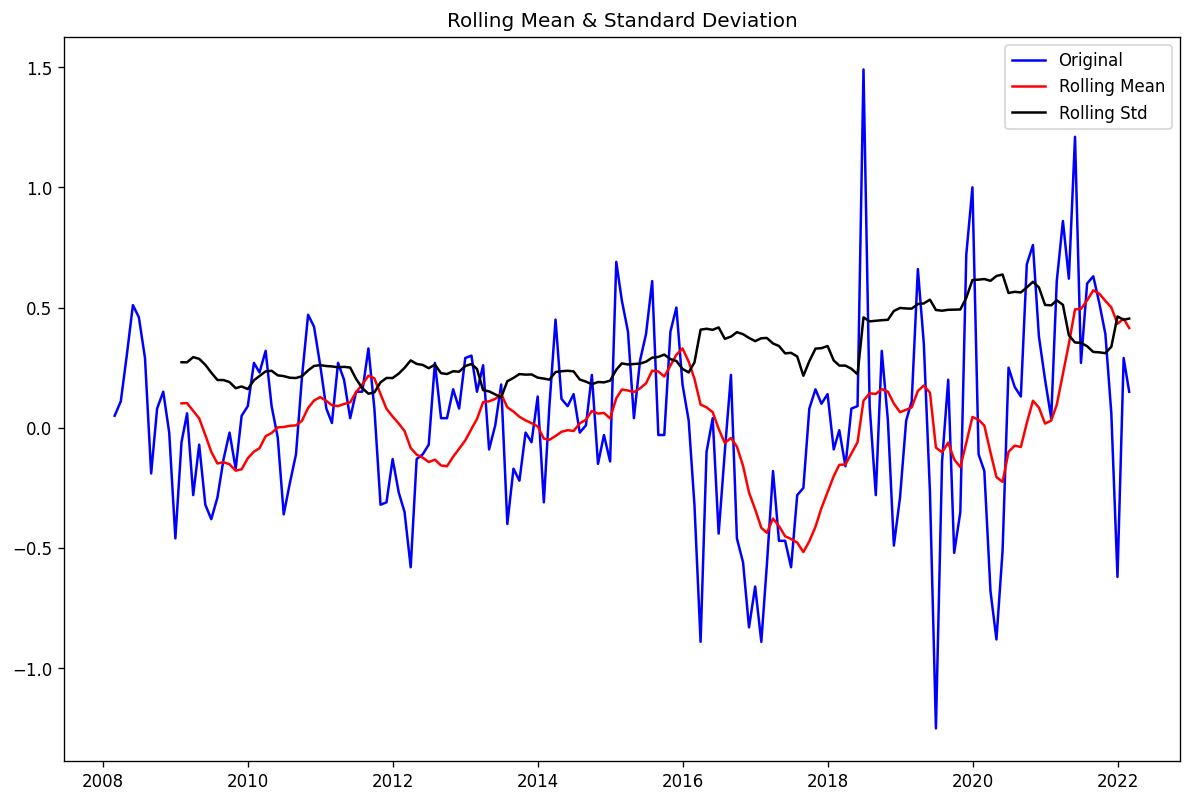

ADF Test Statistic : -4.9499140941076565
p-value : 2.7857291178039197e-05
#Lags Used : 11
Number of Observations Used : 157
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [32]:
data['Seasonal First Difference'] = data['ipca_mensal']-data['ipca_mensal'].shift(12)
adfuller_test(data['Seasonal First Difference'].dropna())

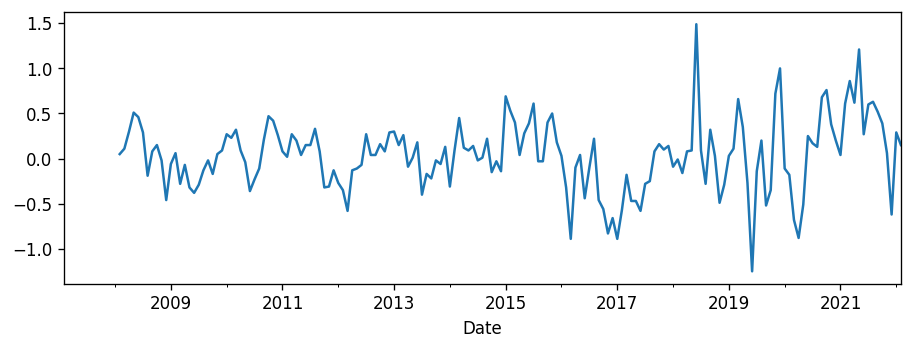

In [35]:
data['Seasonal First Difference'].plot();

In [49]:
data

ipca_mensal  Seasonal First Difference
Date                                              
2007-02-28         0.44                        NaN
2007-03-31         0.37                        NaN
2007-04-30         0.25                        NaN
2007-05-31         0.28                        NaN
2007-06-30         0.28                        NaN
...                 ...                        ...
2021-10-31         1.25                       0.39
2021-11-30         0.95                       0.06
2021-12-31         0.73                      -0.62
2022-01-31         0.54                       0.29
2022-02-28         1.01                       0.15

[181 rows x 2 columns]

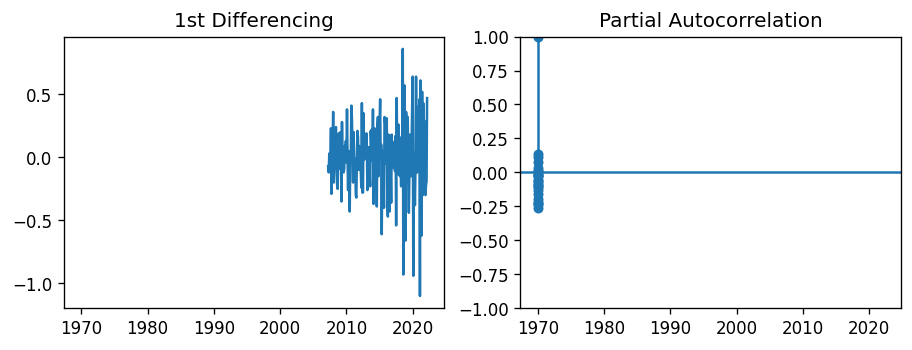

In [18]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data.ipca_mensal.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(data.ipca_mensal.diff().dropna(), ax=axes[1])

plt.show()

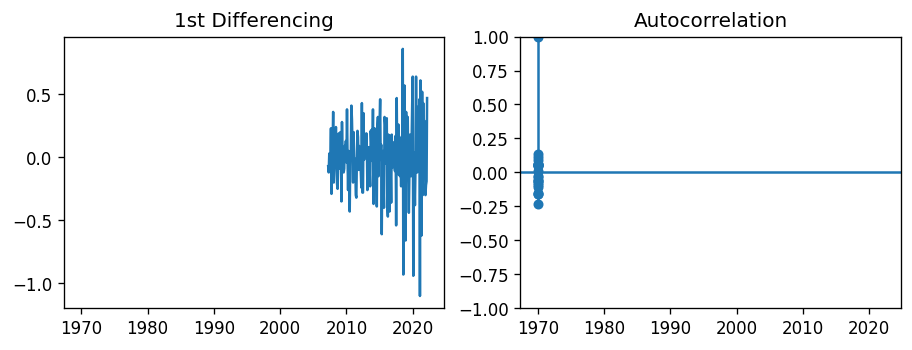

In [19]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(data.ipca_mensal.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(data.ipca_mensal.diff().dropna(), ax=axes[1])

plt.show()

# Criando um AUTO ARIMA MODEL

Separando os dados em treino e teste:

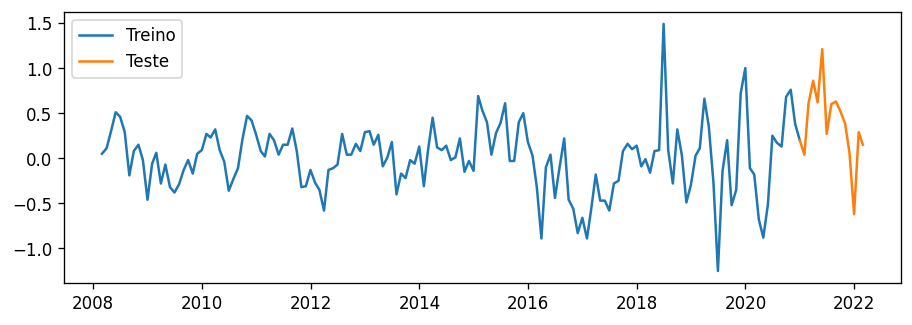

In [61]:
train = data['Seasonal First Difference'][:'2021-01-01'].dropna()
test = data['Seasonal First Difference']['2020-12-01':]
plt.plot(train, label= 'Treino')
plt.plot(test, label= 'Teste')
plt.legend()

Setando os parametros para criação do modelo Arima

In [39]:
arima_model =  pm.auto_arima(train,
                          start_P=1, #P de componentes sazonais (P = número de lags)
                          start_Q=1, #Q de componentes sazonais (Q = MA)
                          max_P=6, 
                          max_Q=6,
                          d=1, #Se não sazonal d=1
                          D=1, #Se sazonal D=1
                          m=12, #Periodo de sazonalidade
                          seasonal=True, #Se é sazonal
                          error_action='warn', #Avisar erro
                          trace = True, #Visualizar saida
                          supress_warnings=True, 
                          stepwise = False, #Vai fazer o processo seguindo a configuração passada quando True "+ rápido"
                          random_state=20,
                          n_jobs= -1, # Número de modelos fitados em parelelo (-1 = máx)
                          n_fits= 50, #Se stewise = False, utilizar n_fits.
                        )


Best model:  ARIMA(0,1,2)(0,1,2)[12]          
Total fit time: 84.816 seconds


In [40]:
print(arima_model.aic()) #AIC do melhor modelo

103.43593847516686


In [41]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  155
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood                 -46.718
Date:                            Tue, 22 Mar 2022   AIC                            103.436
Time:                                    21:41:57   BIC                            118.215
Sample:                                         0   HQIC                           109.442
                                            - 155                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3627      0.069     -5.232      0.000      -0.499      -0.227
ma.L2         -0.3680      0.094     -3.896      0.000      -0.553      -0.183
ma.S.L12      -1.6042      0.102    -15.798      0.000      -1.803      -1.405
ma.S.L24       0.6771      0.099      6.816      0.000       0.482       0.872
sigma2         0.0823      0.008     10.324      0.000       0.067       0.098
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                35.26
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               3.76   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
prediction = pd.DataFrame(arima_model.predict(n_periods= 15), index=test.index)
prediction.columns = ['preditect_ipca']
prediction

preditect_ipca
Date                      
2020-12-31        0.537765
2021-01-31        0.398057
2021-02-28        0.544716
2021-03-31        0.682532
2021-04-30        0.687775
2021-05-31        0.388701
2021-06-30        0.255893
2021-07-31        0.163849
2021-08-31       -0.030283
2021-09-30       -0.083251
2021-10-31       -0.160545
2021-11-30       -0.121497
2021-12-31       -0.036253
2022-01-31        0.050852
2022-02-28        0.060368

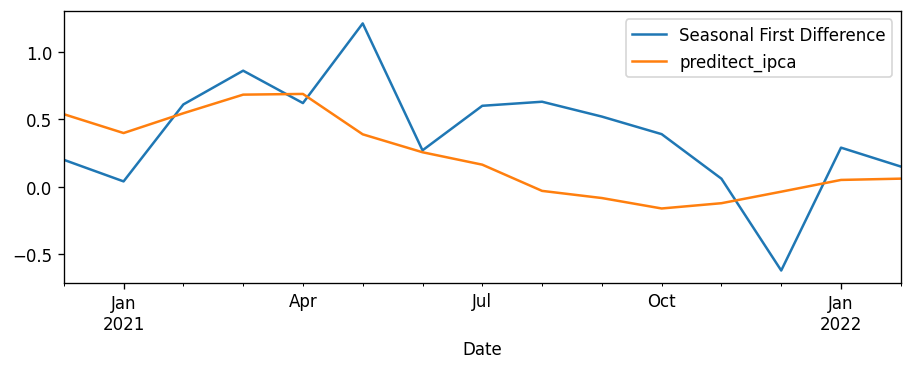

In [43]:
pd.concat([test, prediction], axis=1).plot();

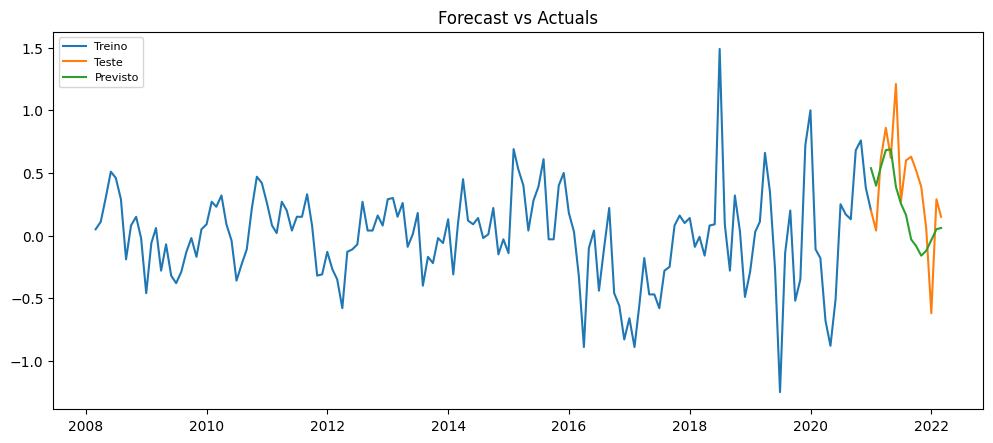

In [44]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label="Treino")
plt.plot(test, label="Teste")
plt.plot(prediction, label="Previsto")
plt.title('Forecast vs Actuals')
plt.legend(loc='best', fontsize=8)
plt.show()

In [84]:
test['preditect_ipca'] = prediction
r2_score(data['Seasonal First Difference']['2020-12-01':], test['preditect_ipca'])

-0.08326905828034259

In [83]:
Data1 = pd.concat([test, prediction], axis=1).dropna().rename(columns={'Seasonal First Difference':'estacionario_1', 'predictect_ipca':'ipca_previsto'})
Data1

estacionario_1  preditect_ipca
Date                                              
2020-12-31 00:00:00            0.2        0.537765
2021-01-31 00:00:00           0.04        0.398057
2021-02-28 00:00:00           0.61        0.544716
2021-03-31 00:00:00           0.86        0.682532
2021-04-30 00:00:00           0.62        0.687775
2021-05-31 00:00:00           1.21        0.388701
2021-06-30 00:00:00           0.27        0.255893
2021-07-31 00:00:00            0.6        0.163849
2021-08-31 00:00:00           0.63       -0.030283
2021-09-30 00:00:00           0.52       -0.083251
2021-10-31 00:00:00           0.39       -0.160545
2021-11-30 00:00:00           0.06       -0.121497
2021-12-31 00:00:00          -0.62       -0.036253
2022-01-31 00:00:00           0.29        0.050852
2022-02-28 00:00:00           0.15        0.060368

# Métricas de acurácia para previsões de séries temporais

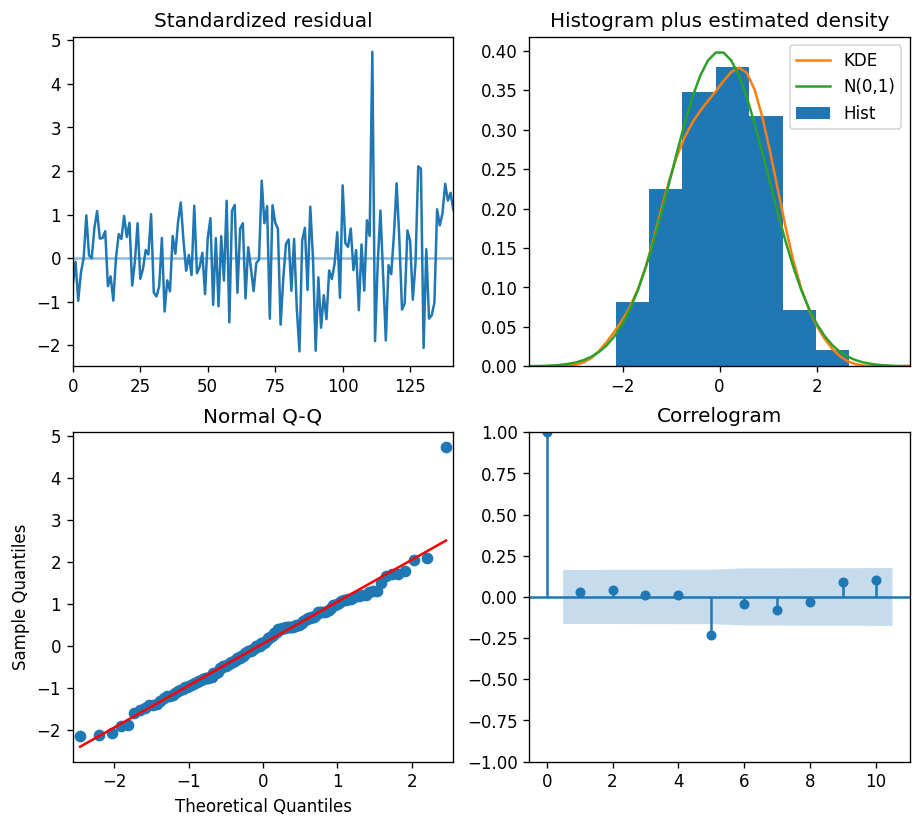

In [50]:
arima_model.plot_diagnostics(figsize=(9,8))
plt.show()